In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Talhão 1

In [34]:
map_name = 'map1'

filepath = f'data/{map_name}/interpolation/universal_interpolated_df.csv'

map1 = pd.read_csv(filepath)

In [35]:
# Função para dividir os dados em features (X) e target (y)
def split_data(df, target_column):
    """
    Split the DataFrame into features (X) and target (y).

    Parameters:
    - df (DataFrame): The input DataFrame.
    - target_column (str): The name of the target column.

    Returns:
    - X (DataFrame): Features (all columns except the target column).
    - y (Series): Target column.
    """
    # Verificar se a coluna alvo está presente no DataFrame
    if target_column not in df.columns:
        raise ValueError(f"A coluna alvo '{target_column}' não está presente no DataFrame.")
    
    # Separar X e y
    X = df.drop(target_column, axis=1)  # X são todas as colunas exceto a coluna alvo
    y = df[target_column]  # y é a coluna alvo
    
    return X, y

# Função para remover as colunas 'latitude' e 'longitude' de um DataFrame
def drop_lat_lon(df):
    """
    Remove 'latitude' and 'longitude' columns from the DataFrame.

    Parameters:
    - df (DataFrame): The input DataFrame.

    Returns:
    - new_df (DataFrame): DataFrame with 'latitude' and 'longitude' columns removed.
    """
    new_df = df.drop(['latitude', 'longitude'], axis=1)
    return new_df

# Função para obter as colunas do DataFrame que correspondem a um padrão regex
def get_bands(df, regex):
    """
    Get columns from the DataFrame that match the specified regex pattern.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - regex (str): Regular expression pattern.

    Returns:
    - new_df (DataFrame): DataFrame with columns matching the regex pattern.
    """
    new_df = df.filter(regex=regex)
    return new_df

# Função para obter as colunas de nutrientes de um DataFrame, excluindo as colunas de bandas
def get_nutrients(df, bands):
    """
    Get nutrient columns from the DataFrame, excluding the specified band columns.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - bands (DataFrame): DataFrame with band columns.

    Returns:
    - new_df (DataFrame): DataFrame with nutrient columns.
    """
    new_df = df.drop(bands.columns, axis=1)
    return new_df

    
map1 = drop_lat_lon(map1)
bands = get_bands(map1, '.tiff')
nutrients = get_nutrients(map1, bands)
nutrients.columns

Index(['N', 'P', 'K', 'Ca', 'Mg', 'S', 'B', 'Cu', 'Fe', 'Mn', 'Zn', 'Mo', 'Ni',
       'Al', 'Se', 'Si', 'Na', 'Va', 'DRIS_N', 'DRIS_P', 'DRIS_K', 'DRIS_Ca',
       'DRIS_Mg', 'DRIS_S', 'DRIS_B', 'DRIS_Cu', 'DRIS_Fe', 'DRIS_Mn',
       'DRIS_Zn', 'IMS', 'IBN'],
      dtype='object')

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Função para plotar a relação da variância explicada pelos componentes principais em uma análise PCA
def plot_variance_ratio(explained_variance_ratio, n_components, title):
    """
    Plot the explained variance ratio for each principal component in a PCA analysis.

    Parameters:
    - explained_variance_ratio (array): Array containing the explained variance ratio for each component.
    - n_components (int): Number of principal components.
    - title (str): Title for the plot.

    Returns:
    - None (displays the plot).
    """
    features = [f"PC{i+1}" for i in range(n_components)]

    fig = px.bar(x=features, y=explained_variance_ratio, labels={'x': 'PCA features', 'y': 'variance %'})
    fig.update_layout(
        title=title,
    )
    fig.show()

# Função para analisar os loadings dos componentes principais em uma análise PCA
def analyze_component_loadings(X, n_components):
    """
    Analyze the component loadings in a PCA analysis.

    Parameters:
    - X (DataFrame): Features DataFrame.
    - n_components (int): Number of principal components.

    Returns:
    - component_loadings_df (DataFrame): DataFrame containing the loadings of each feature for each principal component.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    # Criando nomes descritivos para as colunas
    component_names = [f'PC{i+1}' for i in range(n_components)]

    # Criando DataFrame com os nomes descritivos e usando os nomes das colunas de X como índice
    component_loadings_df = pd.DataFrame(pca.components_, columns=X.columns, index=component_names).T

    return component_loadings_df

# Função para calcular a PCA e retornar os componentes principais e a variância explicada
def calculate_PCA(X, n_components):
    """
    Calculate PCA and return the principal components and explained variance.

    Parameters:
    - X (DataFrame): Features DataFrame.
    - n_components (int): Number of principal components.

    Returns:
    - new_df (DataFrame): DataFrame containing the principal components.
    - explained_variance_ratio (array): Array containing the explained variance ratio for each component.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    new_df = pd.DataFrame(principal_components, columns=[f"PC{i}" for i in range(n_components)])

    explained_variance_ratio = pca.explained_variance_ratio_

    return new_df, explained_variance_ratio

# Função para encontrar o número ótimo de componentes principais para atingir uma variância explicada desejada
def find_optimal_pca_components(X, explained_variance_threshold=0.9):
    """
    Find the optimal number of principal components to achieve a desired explained variance.

    Parameters:
    - X (DataFrame): Features DataFrame.
    - explained_variance_threshold (float): Desired cumulative explained variance.

    Returns:
    - n_components (int): Optimal number of principal components.
    """
    # Normaliza os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calcula a PCA
    pca = PCA()
    pca.fit(X_scaled)

    # Calcula a variância explicada cumulativa
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Encontra o número de componentes onde a variância explicada ultrapassa o limiar desejado
    n_components = np.argmax(explained_variance >= explained_variance_threshold) + 1

    return n_components

n_components = find_optimal_pca_components(bands)
print(f"O número ótimo de componentes é {n_components}.")

pca_df, explained_variance_ratio = calculate_PCA(bands, n_components)

plot_variance_ratio(explained_variance_ratio, n_components, title="Variance Ratio")

O número ótimo de componentes é 3.


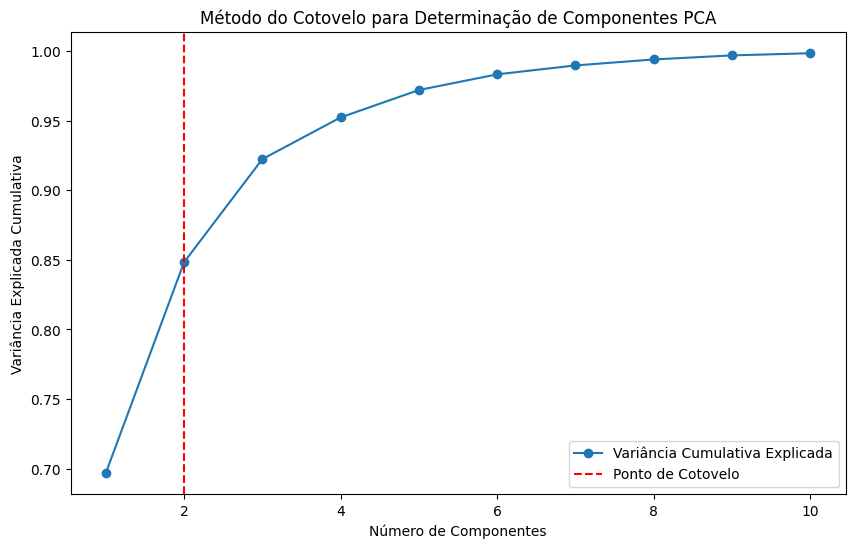

2

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Função para aplicar o método do cotovelo na determinação do número ótimo de componentes para PCA
def elbow_method(X, max_components=None):
    """
    Apply the elbow method to determine the optimal number of components for PCA.

    Parameters:
    - X (DataFrame): Features DataFrame.
    - max_components (int): Maximum number of components to consider. Default is the minimum of rows and columns in X.

    Returns:
    - suggested_components (int): Optimal number of principal components suggested by the elbow method.
    """
    # Normalizando os dados
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Determinando o número máximo de componentes se não fornecido
    if max_components is None:
        max_components = min(X.shape[0], X.shape[1])

    # Aplicando PCA para diferentes números de componentes
    num_components = np.arange(1, max_components + 1)
    explained_variances = []

    for n in num_components:
        pca = PCA(n_components=n)
        pca.fit(X_scaled)
        explained_variances.append(np.sum(pca.explained_variance_ratio_))

    # Encontrando o número sugerido de componentes usando o método do cotovelo
    elbow_index = np.argmin(np.diff(explained_variances, 2)) + 1
    suggested_components = num_components[elbow_index]

    # Plotando o gráfico do método do cotovelo com melhorias
    plt.figure(figsize=(10, 6))
    plt.plot(num_components, explained_variances, marker='o', label='Variância Cumulativa Explicada')
    plt.axvline(x=suggested_components, color='red', linestyle='--', label='Ponto de Cotovelo')

    # Adicionando rótulos e título
    plt.title('Método do Cotovelo para Determinação de Componentes PCA')
    plt.xlabel('Número de Componentes')
    plt.ylabel('Variância Explicada Cumulativa')
    
    # Adicionando legenda
    plt.legend()

    plt.show()

    return suggested_components
    
        
elbow_n_components = elbow_method(bands, 10)
elbow_n_components

In [38]:
component_loadings_df = analyze_component_loadings(bands, n_components)
component_loadings_df

,PC1,PC2,PC3
B01.tiff,0.296351,0.086937,-0.044694
B02.tiff,0.295940,0.245135,0.070756
B03.tiff,0.261569,0.375867,0.103574
B04.tiff,0.313789,0.093236,0.072255
B05.tiff,0.307920,0.150229,0.072644
B06.tiff,-0.295892,0.303699,0.025433
B07.tiff,-0.303350,0.272031,0.017500
B08.tiff,-0.293037,0.280452,0.000048
B09.tiff,-0.260895,0.344474,0.005659
B10.tiff,0.068805,0.093055,-0.985041


In [39]:
# Função para plotar o gráfico de soma cumulativa da variância explicada pelos componentes principais em uma análise PCA
def plot_cumulative_sum_variance(cumulative_variance, n_components):
    """
    Plot the cumulative sum of explained variance by principal components in a PCA analysis.

    Parameters:
    - cumulative_variance (array): Array containing the cumulative sum of explained variance ratio.
    - n_components (int): Number of principal components.

    Returns:
    - None (displays the plot).
    """
    feature_names = [f"PC{i}" for i in range(1, n_components + 1)]

    # Plot cumulative variance
    fig = px.line(x=feature_names, y=cumulative_variance, markers=True, labels={'x': 'Principal Components', 'y': 'Acumulated Variance Ratio'})
    fig.update_layout(title='Acumulated Variance Ratio')

    fig.show()
    
cumulative_variance = np.cumsum(explained_variance_ratio)
plot_cumulative_sum_variance(cumulative_variance, n_components)

In [40]:
import plotly.subplots as sp

def plot_loadings_all_components(loadings_df, title='Principal Components Loadings', vertical_spacing=0.1):
    num_components = loadings_df.shape[1]  # Number of principal components

    # Create the figure with subplots
    fig = sp.make_subplots(rows=num_components, cols=1, subplot_titles=[f'PC{i+1} Loadings' for i in range(num_components)],
                           shared_xaxes=True, vertical_spacing=vertical_spacing)

    # Add traces for each principal component
    for i, component in enumerate(loadings_df.columns):
        trace = go.Bar(x=loadings_df.index, y=loadings_df[component], name=f'PC{i+1} Loadings')
        fig.add_trace(trace, row=i+1, col=1)

    # Update the layout of the figure
    fig.update_layout(height=300*num_components, showlegend=False, title_text=title)

    # Show x-axis labels on all subplots
    for i in range(num_components):
        fig.update_xaxes(title_text='Features', showticklabels=True, row=i+1, col=1)

    fig.update_yaxes(title_text='Loadings', col=1)

    # Show the figure
    fig.show()



plot_loadings_all_components(component_loadings_df.abs(), title='Pesos das variáveis nos Componentes Principais')

In [41]:
pca_df

,PC0,PC1,PC2
0,4.563340,-3.298440,1.651030
1,5.817202,-3.127366,1.803800
2,5.866571,-2.570051,1.854887
3,5.622967,-1.778811,1.916744
4,6.234013,-1.123354,2.102168
...,...,...,...
9450,11.796278,5.703156,1.437968
9451,10.865890,4.667273,1.187620
9452,10.009402,3.391598,0.890385
9453,9.419184,1.927657,0.567871


In [42]:
# Plot pc1 e pc2
fig = px.scatter(pca_df, x='PC0', y='PC1', title='Visualização dos componentes principais')
fig.show()

In [43]:
# pca_feature_importance_df = process_multiple_targets(pca_df, nutrients, methods=['linear_regression', 'random_forest'])

# feature_importance_plot(pca_feature_importance_df, title="Feature Importance com PCA")

# Talhão 2

In [44]:
map_name = 'map2'

filepath = f'data/{map_name}/interpolation/universal_interpolated_df.csv'

map2 = pd.read_csv(filepath)

map2 = drop_lat_lon(map2)
bands = get_bands(map2, '.tiff')
nutrients = get_nutrients(map2, bands)
nutrients.columns

Index(['N', 'P', 'K', 'Ca', 'Mg', 'S', 'B', 'Cu', 'Fe', 'Mn', 'Zn', 'Mo', 'Ni',
       'Al', 'Se', 'Si', 'Na', 'Va', 'DRIS_N', 'DRIS_P', 'DRIS_K', 'DRIS_Ca',
       'DRIS_Mg', 'DRIS_S', 'DRIS_B', 'DRIS_Cu', 'DRIS_Fe', 'DRIS_Mn',
       'DRIS_Zn', 'IMS', 'IBN'],
      dtype='object')

In [45]:
n_components = find_optimal_pca_components(bands)
print(f"O número ótimo de componentes é {n_components}.")

pca_df, explained_variance_ratio = calculate_PCA(bands, n_components)

plot_variance_ratio(explained_variance_ratio, n_components, title="Variance Ratio")

O número ótimo de componentes é 3.


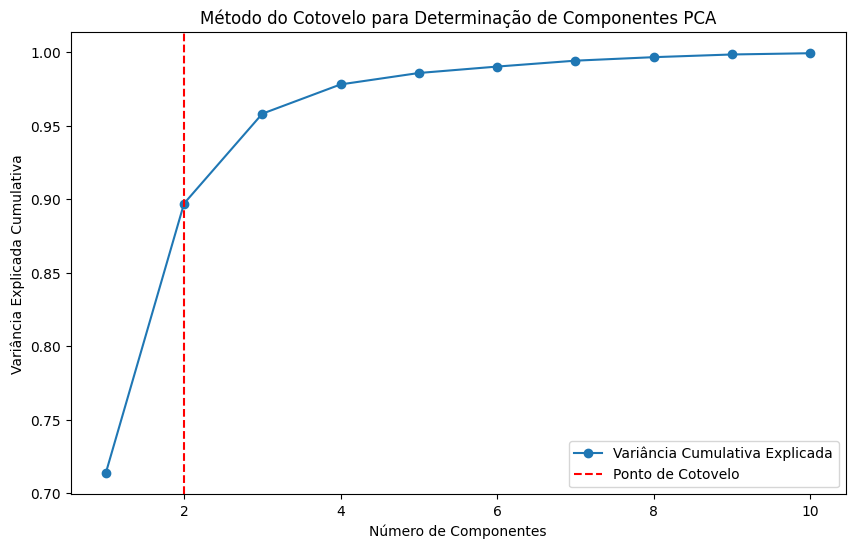

2

In [46]:
elbow_n_components = elbow_method(bands, 10)
elbow_n_components

In [47]:
component_loadings_df = analyze_component_loadings(bands, n_components)
cumulative_variance = np.cumsum(explained_variance_ratio)
plot_cumulative_sum_variance(cumulative_variance, n_components)

In [48]:
plot_loadings_all_components(component_loadings_df.abs(), title='Pesos das variáveis nos Componentes Principais')

In [49]:
# Plot pc1 e pc2
fig = px.scatter(pca_df, x='PC0', y='PC1', title='Visualização dos componentes principais')
fig.show()